# Final Project: Load balancing
## Part 2 : Tabular Model-Free control

#### Temporal-Difference Learning

Author : Jed MOUTAHIR

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return -(self.state[0] + self.state[1])
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        elif(event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        elif(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max and event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 == self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 == self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1
        else:
            if((self.Q1 > self.Q1_max or self.Q2 > self.Q2_max) and (event < self.mu1 + self.mu2 + self.lambdA)):
                print("Error: impossible state : ")
                print("Q1 = ", self.Q1)
                print("Q2 = ", self.Q2)
                print("event = ", event)
                print("action = ", action)
                print("lambdA = ", self.lambdA)
                print("mu1 = ", self.mu1)
                print("mu2 = ", self.mu2)

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [45]:
def TD_0(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, alpha=0.1, eps=1e-5):
    """ Function that implements the TD(0) algorithm. """

    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)

    # Initialize value function with zeros
    V = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))

    for i in np.arange(N):
        for s in [(i, j) for i in np.arange(env.Q1_max+1) for j in np.arange(env.Q2_max+1)]:
            # Initial state
            # Random initial state
            #state = (np.random.randint(0, env.Q1_max+1), np.random.randint(0, env.Q2_max+1))
            for action in env.actions:

                state = s

                # Next state and reward
                reward, next_state = env.step(action)

                # Update value function
                V[state[0], state[1], action] += alpha*(reward + gamma*V[next_state[0], next_state[1], action] - V[state[0], state[1], action])

                # Update state
                state = next_state

                for j in np.arange(100):
                    # Random action
                    action = np.random.choice(env.actions)

                    # Next state and reward
                    reward, next_state = env.step(action)

                    # Update value function
                    V[state[0], state[1], action] += alpha*(reward + gamma*V[next_state[0], next_state[1], action] - V[state[0], state[1], action])

                    # Update state
                    state = next_state

    print("Value function: ", V[:, :, :])

    # Initialize policy with zeros
    policy = np.zeros((env.Q1_max+1, env.Q2_max+1))

    # Compute optimal policy
    for i in np.arange(env.Q1_max+1):
        for j in np.arange(env.Q2_max+1):
            if(V[i, j, 0] > V[i, j, 1]):
                policy[i, j] = 0
            elif(V[i, j, 0] < V[i, j, 1]):
                policy[i, j] = 1
            else:
                policy[i, j] = 0.5

    return V, policy

In [62]:
# Parameters
lambdA = 0.4
mu1 = 0.2
mu2 = 0.2
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [63]:
# Compute optimal policy using TD(0)
N = 100
V, policy = TD_0(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N)

Value function:  [[[-1569.24865317  -903.18326941]
  [-1549.74929771  -905.69614971]
  [-1537.96320333  -930.83518642]
  [-1522.17123069  -957.38137934]
  [-1510.93476421  -977.09113324]
  [-1516.83810667 -1011.66112351]
  [-1530.58734433 -1088.24519985]
  [-1543.0984546  -1154.1723421 ]
  [-1551.52571797 -1184.66014467]
  [-1568.38556004 -1222.32188617]
  [-1577.30283661 -1266.52047424]
  [-1610.04872652 -1312.32798472]
  [-1647.84391356 -1378.0275661 ]
  [-1677.93590784 -1398.070059  ]
  [-1702.17822895 -1432.33064246]
  [-1728.47584414 -1474.00585187]
  [-1760.12775346 -1503.43472927]
  [-1804.40492511 -1556.47067612]
  [-1838.7617459  -1576.99290028]
  [-1895.31649792 -1596.2464232 ]
  [-1886.89626676 -1601.8687937 ]]

 [[-1594.24198817  -911.26553711]
  [-1570.05763759  -921.46257823]
  [-1559.68133841  -963.07334579]
  [-1539.98327866 -1010.2085445 ]
  [-1526.66167395 -1042.24111806]
  [-1533.60960637 -1103.27713837]
  [-1548.14206077 -1169.41481833]
  [-1567.87041972 -1212.09412

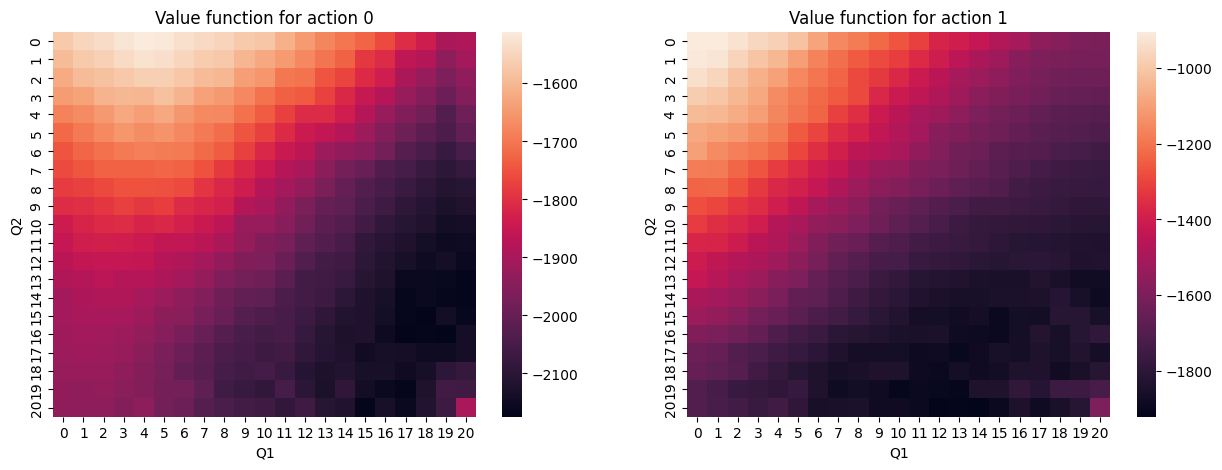

In [64]:
# Plot the value function using sns
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(V[:, :, 0], ax=ax[0])
sns.heatmap(V[:, :, 1], ax=ax[1])
ax[0].set_title("Value function for action 0")
ax[1].set_title("Value function for action 1")
ax[0].set_xlabel("Q1")
ax[0].set_ylabel("Q2")
ax[1].set_xlabel("Q1")
ax[1].set_ylabel("Q2")
plt.show()

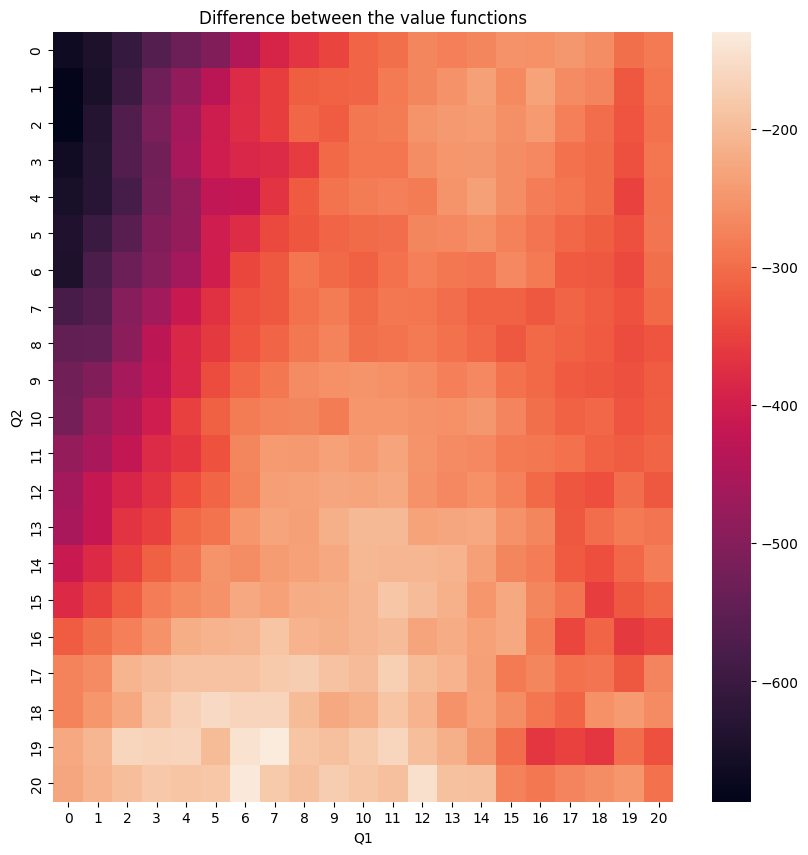

In [65]:
# Plot the difference between the value functions
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(V[:, :, 0] - V[:, :, 1])
ax.set_title("Difference between the value functions")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.show()

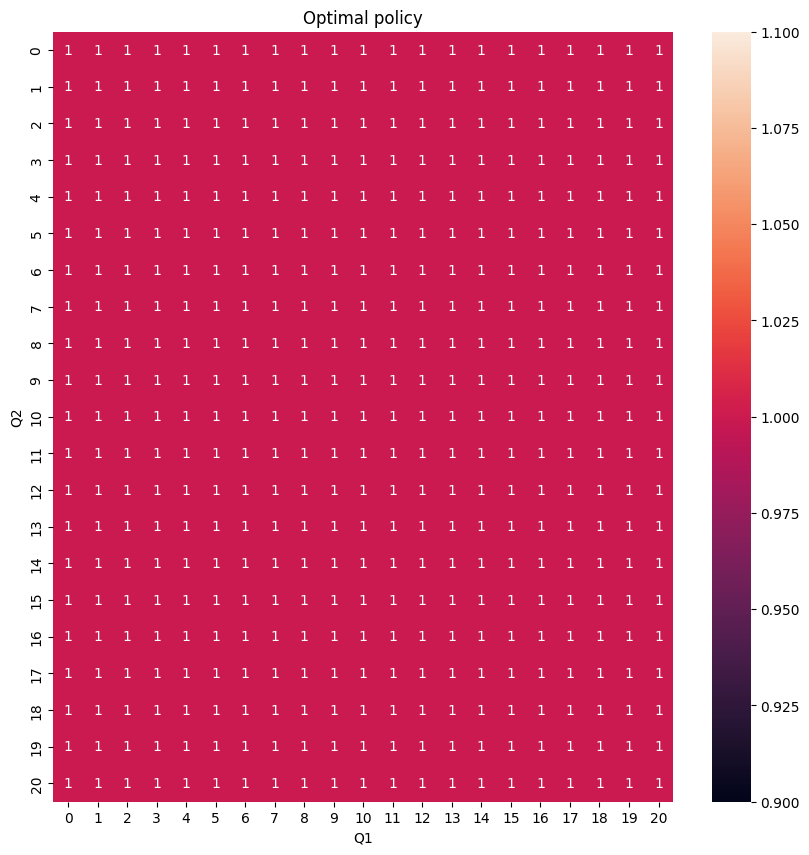

In [66]:
# Plot the optimal policy
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(policy, annot=True, ax=ax)
ax.set_title("Optimal policy")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.show()

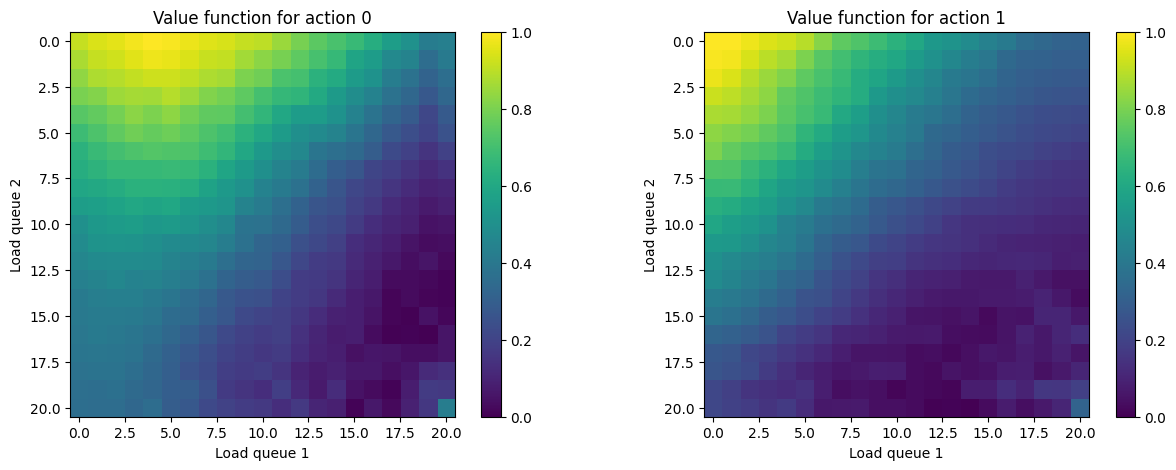

In [67]:
normed_V = V[:, :, :]
# Map the value function to [0, 1]
normed_V[:, :, 0] = (V[:, :, 0] - np.min(V[:, :, 0]))/(np.max(V[:, :, 0]) - np.min(V[:, :, 0]))
normed_V[:, :, 1] = (V[:, :, 1] - np.min(V[:, :, 1]))/(np.max(V[:, :, 1]) - np.min(V[:, :, 1]))

# Plot the value function
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(normed_V[:, :, 0])
ax[0].set_xlabel("Load queue 1")
ax[0].set_ylabel("Load queue 2")
ax[0].set_title("Value function for action 0")
ax[1].imshow(normed_V[:, :, 1])
ax[1].set_xlabel("Load queue 1")
ax[1].set_ylabel("Load queue 2")
ax[1].set_title("Value function for action 1")
plt.colorbar(ax[0].imshow(normed_V[:, :, 0]), ax=ax[0])
plt.colorbar(ax[1].imshow(normed_V[:, :, 1]), ax=ax[1])
plt.show()

In [68]:
# Compute the optimal policy using the normed value function
normed_policy = np.zeros((Q1_max+1, Q2_max+1))
for i in np.arange(Q1_max+1):
    for j in np.arange(Q2_max+1):
        if(normed_V[i, j, 0] > normed_V[i, j, 1]):
            normed_policy[i, j] = 0
        elif(normed_V[i, j, 0] < normed_V[i, j, 1]):
            normed_policy[i, j] = 1
        else:
            normed_policy[i, j] = 0.5

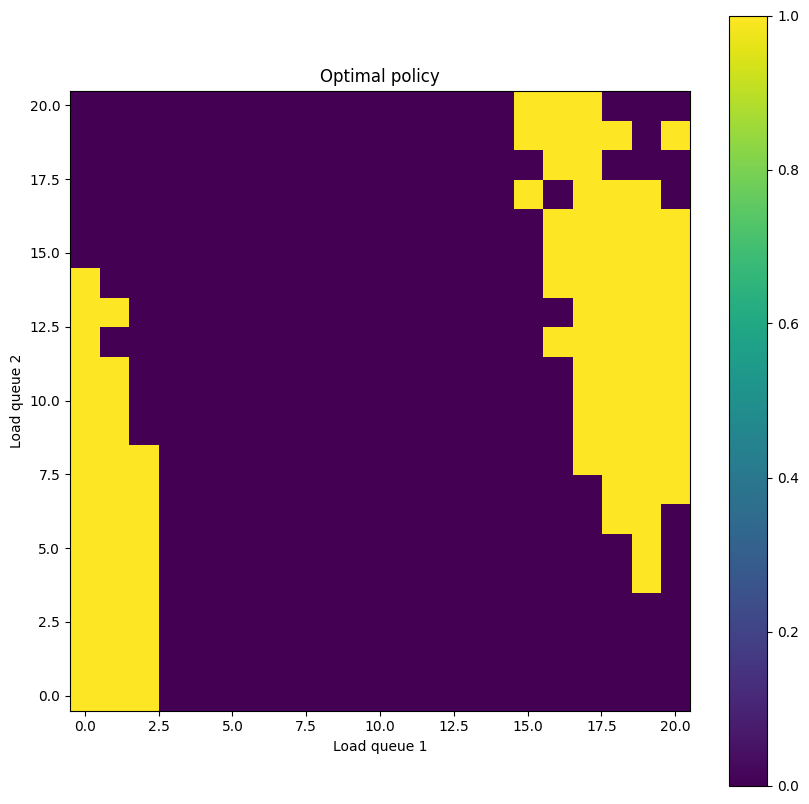

In [69]:
# Plot the optimal policy using the normed value function
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(-0.5, Q1_max +0.5)
plt.ylim(-0.5, Q2_max +0.5)
plt.xlabel("Load queue 1")
plt.ylabel("Load queue 2")
plt.title("Optimal policy")
plt.imshow(normed_policy)
plt.colorbar()
plt.show()